In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import os, sys
import datetime
runtime = os.path.abspath((sys.argv[0])) + " run at " + datetime.datetime.now().strftime("%c")
tyb = dict(color='black', fontsize=20) 
import betapic_c as bp
from kepler3 import *
from exorings3 import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib
#from textwrap import wrap
from PIL import Image
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'font.size': 17})

if (len(sys.argv)<2):
    print('Error: you must specify a fractional radius of CPD to be searched for.')
    print('    usage: ./python {} 0.30'.format(sys.argv[0]))
    pass
    #sys.exit() #quit()

In [2]:
b = 0.1 #fraction hill sphere for impact parameter

#vary between the two fractions of the hill sphere
f_hill = 0.3
#f_hill = 0.6 

#vary between the two
t_mid = 58210. * u.day #first primary transit
#t_mid = 59413. * u.day #second primary transit

print('Compute the circumplanetary disk using a radius of Hill sphere disk in fraction of Hill radius is {:.3f} at transit midpoint of {}'.format(f_hill, t_mid))


Compute the circumplanetary disk using a radius of Hill sphere disk in fraction of Hill radius is 0.300 at transit midpoint of 58210.0 d


In [3]:
#import data from ASTEP, BRITE and bRing
f_bring = Table.read('Data/binned_BRING.dat', format='ascii.ecsv')
f_astep = Table.read('Data/binned_ASTEP.dat', format='ascii.ecsv')
f_brite = Table.read('Data/binned_BRITE.dat', format='ascii.ecsv')
# remove any anomalously low error bars from the BRING data and set them with 1% errors
m=(f_bring['ferr']<0.002)
f_bring['ferr'][m] = 0.01

# calculate Hill sphere for beta pic b
r_hill = rhill(bp.M_star, bp.M_b, bp.a_b).to(u.au) # radius of hill sphere
print('Hill sphere radius {:5.3f}'.format(r_hill))

r_disk = r_hill * f_hill # radius of disk
print('Disk radius is {:5.3f}'.format(r_disk))

angle_i = 30    # inclination of the disk in degrees
angle_phi = 80  # tilt of the disk in degrees

impact_b = b*r_hill # impact parameter of the star
print('Impact parameter distance {:5.3f}'.format(impact_b))

vplanet = vcirc(bp.M_star, bp.M_b, bp.a_b)
print('circular velocity at planet is {:5.3f}'.format(vplanet))

# okay, we need a simple function to convert time to x position w.r.t. the planet
# this should be the full kepler orbit, but we'll go with:
def xp(t, t_mid, vtrans):
    return ((t-t_mid)*vtrans).to(u.au)

from lmfit import Model
gmodel = Model(disk_lc_model, independent_vars=['x','xlower','xupper'])
print('parameter names: {}'.format(gmodel.param_names))
print('independent variables: {}'.format(gmodel.independent_vars))

params = gmodel.make_params(deltadisk=0.0, foutside=1.0, xlower=1.8, xupper=3.4)

# number of points in the sampling grid for the plots
n_i = 25
n_phi = 39

i_range = np.linspace(10, 90, n_i)
phi_range = np.linspace(0, 180, n_phi)

def fitdisk(x_coord, f, ferr, i_range, phi_range, r_disk, gmodel, params):
    deltaf = np.ma.zeros((i_range.size,phi_range.size))
    redchisq = np.ma.zeros((i_range.size,phi_range.size))
    deltaf_err = np.ma.zeros((i_range.size,phi_range.size))
    fout = np.ma.zeros((i_range.size,phi_range.size))
    fout_err = np.ma.zeros((i_range.size,phi_range.size))
    sanity = np.ma.zeros((i_range.size,phi_range.size))
    npoints = np.ma.zeros((i_range.size,phi_range.size))
    success = np.ma.zeros((i_range.size,phi_range.size))

    deltaf.mask = True
    redchisq.mask = True
    deltaf_err.mask = True
    fout.mask = True
    fout_err.mask = True
    sanity.mask = True
    npoints.mask = True
    success.mask = True

    for i, curr_i in enumerate(i_range):
        for j, curr_phi in enumerate(phi_range):

            (xring, yring, radring) = sky_to_ring(x_coord, impact_b, curr_i, curr_phi)
            indisk2 = (radring < r_disk)
            nindisk = np.sum(indisk2)
            npoints[i][j] = nindisk
            if (nindisk > 10):

                # find the edges of the disk region
                xp_lower = np.min(x_coord[indisk2])
                xp_upper = np.max(x_coord[indisk2])

                result = gmodel.fit(f, params, x=x_coord, xlower=xp_lower, xupper=xp_upper, weights=1./(ferr))
                deltaf[i][j] = result.params['deltadisk'].value
                redchisq[i][j] = result.redchi
                deltaf_err[i][j] = result.params['deltadisk'].stderr
                fout[i][j] = result.params['foutside'].value
                fout_err[i][j] = result.params['foutside'].stderr
                success[i][j] = result.success

                sanity[i][j] = curr_i

    # propagate the errors for fout and
    # I = I_0 exo(-tau.cos(i))
    # taylor it...
    # I = I_0 * (1 - tau.cos(i))
    # I = I_0 - I_0 tau cos i)
    # tau cos(i) = (I_0 - I)/I0
    # tau cos(i) = 1 - I/I0
    # tau cos(i) = 1 - (fout-deltaf)/fout
    # tau cos(i) = deltaf/fout
    
    tau = deltaf/fout
    tau_err = np.power(np.power((deltaf_err/deltaf),2.)+np.power((fout_err/fout),2),0.5)*tau

    # returning a dict because I'm not sure how much data I'll be returning
    ans_dict = {'redchisq': redchisq, 'df': deltaf, 'dfe':deltaf_err, 'f0':fout, 'f0e':fout_err, 'tau':tau, 'taue':tau_err, 'npoints':npoints, 'success':success}
    return ans_dict

f=f_brite['flux']+1.0
x_coord = xp(f_brite['time'] * u.day, t_mid, vplanet )
ferr = f_brite['ferr']
(brite_disk) = fitdisk(x_coord, f, ferr, i_range, phi_range, r_disk, gmodel, params)

f=f_bring['flux']+1.0
x_coord = xp(f_bring['time'] * u.day, t_mid, vplanet )
ferr = f_bring['ferr']
(bring_disk) = fitdisk(x_coord, f, ferr, i_range, phi_range, r_disk, gmodel, params)

f=f_astep['flux']+1.0
x_coord = xp(f_astep['time'] * u.day, t_mid, vplanet )
ferr = f_astep['ferr']
(astep_disk) = fitdisk(x_coord, f, ferr, i_range, phi_range, r_disk, gmodel, params)

def plot_diskfit2(d, dataname, i_range, phi_range):
    'plots disk fit results in 2 panels, requires a dict from the disk fitting routine'
    fig2, f2_axes = plt.subplots(2, 1, figsize=(7,8), constrained_layout=False)
    (ax1,ax2) = f2_axes.flatten()

    # sets the extent=() limits in imshow() so that the centre of each pixel corresponds to i and phi value
    i_min = i_range.min()
    i_max = i_range.max()
    di = 0.5*((i_max-i_min)/(i_range.size-1))

    phi_min = phi_range.min()
    phi_max = phi_range.max()
    dphi = 0.5*((phi_max-phi_min)/(phi_range.size-1))

    im1 = ax1.imshow(d['tau'],
                     extent=(phi_min-dphi,phi_max+dphi,i_min-di,i_max+di),
                     cmap='viridis',
                     origin='lower'
                     )
    
    im2 = ax2.imshow(d['tau']/d['taue'],
                     extent=(phi_min-dphi,phi_max+dphi,i_min-di,i_max+di),
                     origin='lower',
                     cmap='viridis'
                     )

    cbar = fig2.colorbar(im1, ax=ax1)
    cbar.formatter.set_powerlimits((0, 0))
    cbar2 = fig2.colorbar(im2, ax=ax2)
    ax1.set_title(r'$\tau\ \sin\ \theta $',
                  fontsize=20
                  )
    ax2.set_title(r'Signal to noise of $\tau\ \sin\ \theta$',
                  fontsize=20
                  )
    
    tyb = dict(color='black', fontsize=18)
    ax1.text(0.05, 0.05, dataname, ha='left', va='bottom', transform=ax1.transAxes, **tyb)
###    ax2.text(0.05, 0.05, runtime, ha='left', va='bottom', transform=ax2.transAxes, fontsize=6)

    for a in f2_axes.flatten():
        a.xaxis.set_major_locator(MultipleLocator(30))
        a.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        a.yaxis.set_major_locator(MultipleLocator(30))
        a.yaxis.set_major_formatter(FormatStrFormatter('%d'))

        # For the minor ticks, use no labels; default NullFormatter.
        a.xaxis.set_minor_locator(MultipleLocator(10))
        a.yaxis.set_minor_locator(MultipleLocator(10))

        a.set_xlim(-10,190)
        a.set_ylim(-10,100)

        a.set_xlabel(r'Tilt $\phi$ [deg]',
                     fontsize=20
                     )
        
        a.set_ylabel(r'Inclination $\theta$ [deg]',
                     fontsize=20
                     )
        #a.scatter(angle_phi, angle_i, color='red')

    plt.tight_layout()
    plt.draw()
    plotout = ('Figures/CPD_models/{}_b{}/diskfit_{}_{:03d}.png'.format(t_mid.value,b,dataname, int(f_hill*100)))
    plt.savefig(plotout)


plot_diskfit2(bring_disk, 'BRING', i_range, phi_range)

plot_diskfit2(astep_disk, 'ASTEP', i_range, phi_range)

plot_diskfit2(brite_disk, 'BRITE', i_range, phi_range)

meantau = np.ma.stack((bring_disk['tau'],brite_disk['tau'],astep_disk['tau']),axis=-1)
sig_tau = np.ma.stack((bring_disk['taue'],brite_disk['taue'],astep_disk['taue']),axis=-1)

upper_tau = meantau + sig_tau

# project back down to first two dims by finding the largest value of upper_tau

# can use min index first so we know which camera was the one with the largest constraint
upper_tau_ind = np.ma.argmax(upper_tau, axis=-1)
upper_tau_max = np.ma.max(upper_tau, axis=-1)

def disk_mass(r_disk, tau, mean_a=0.5*u.micron, mean_rho=2.5*u.g/(u.cm*u.cm*u.cm)):
    'simple mass for a face-on circular optically thin disk'
    # cadged from Mellon's derivation in thesis - p.44, eq. 4.9
    Mdisk = (4*np.pi*mean_a*mean_rho*tau*r_disk*r_disk)/3.
    return Mdisk.to(u.g)

mean_a = 33. * np.sqrt(f_hill) *u.micron # from Grant Kennedy, in Section 4

print('mean a for the particle size is {:.1e}'.format(mean_a))
print('estimated thin disk mass: {:.1e}'.format(disk_mass(1*u.au, 1e-3, mean_a = mean_a)))

# mass estimate from ALMA Perez et al. 2019a.
print('Mass estimate from Perez+ 2019: {:.1e}'.format((bp.M_b * 5e-8).to(u.g)))

def plot_disktaumass(tau, i_range, phi_range):
    'plots disk fit results in 4 panels, requires a dict from the disk fitting routine'
    fig2, f2_axes = plt.subplots(2, 1, figsize=(7,8), constrained_layout=False)
    (ax1,ax2) = f2_axes.flatten()

    # sets the extent=() limits in imshow() so that the centre of each pixel corresponds to i and phi value
    i_min = i_range.min()
    i_max = i_range.max()
    di = 0.5*((i_max-i_min)/(i_range.size-1))

    phi_min = phi_range.min()
    phi_max = phi_range.max()
    dphi = 0.5*((phi_max-phi_min)/(phi_range.size-1))

    tau_face_on = tau * (np.sin(i_range*np.pi/180.))[:,np.newaxis]
    dmass = disk_mass(r_disk, np.ma.filled(tau_face_on, 0.0), mean_a = mean_a)
    
    im1 = ax1.imshow(tau_face_on, extent=(phi_min-dphi,phi_max+dphi,i_min-di,i_max+di),cmap='viridis', origin='lower')
    im2 = ax2.imshow(dmass.value,    extent=(phi_min-dphi,phi_max+dphi,i_min-di,i_max+di), origin='lower',cmap='viridis')


    print('For disk hill radius {:.2f} we have an upper mass of {:.2e}'.format(f_hill, np.max(dmass.value)))
    
    cbar = fig2.colorbar(im1, ax=ax1)
    cbar.formatter.set_powerlimits((0, 0))
    cbar2 = fig2.colorbar(im2, ax=ax2)
    ax1.set_title(r'Upper limit on $\tau$ corrected for inclination', fontsize =15)
    ax2.set_title(r'Upper mass of CPD assuming a={:.1f}'.format(mean_a), fontsize =15)
    
    tyb = dict(color='black', fontsize=18)

    for a in f2_axes.flatten():
        a.tick_params(axis='both', which='major', labelsize=14, width=2.5, length=10)
        a.xaxis.set_major_locator(MultipleLocator(30))
        a.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        a.yaxis.set_major_locator(MultipleLocator(30))
        a.yaxis.set_major_formatter(FormatStrFormatter('%d'))

        # For the minor ticks, use no labels; default NullFormatter.
        a.xaxis.set_minor_locator(MultipleLocator(10))
        a.yaxis.set_minor_locator(MultipleLocator(10))

        a.set_xlim(-10,190)
        a.set_ylim(-10,100)
        a.set_xlabel(r'Tilt $\phi$ [deg]')
        a.set_ylabel(r'Inclination $ \theta $ [deg]')


    plt.tight_layout()

    plt.draw()

    
    
    plotout = ('Figures/CPD_models/{}_b{}/diskfit_taumass_{:03d}.png'.format(t_mid.value, b,int(f_hill*100)))
    plt.savefig(plotout)

plot_disktaumass(upper_tau_max, i_range, phi_range)

plt.show()

Hill sphere radius 0.307 AU
Disk radius is 0.092 AU
Impact parameter distance 0.031 AU
circular velocity at planet is 24.444 km / s


ModuleNotFoundError: No module named 'lmfit'

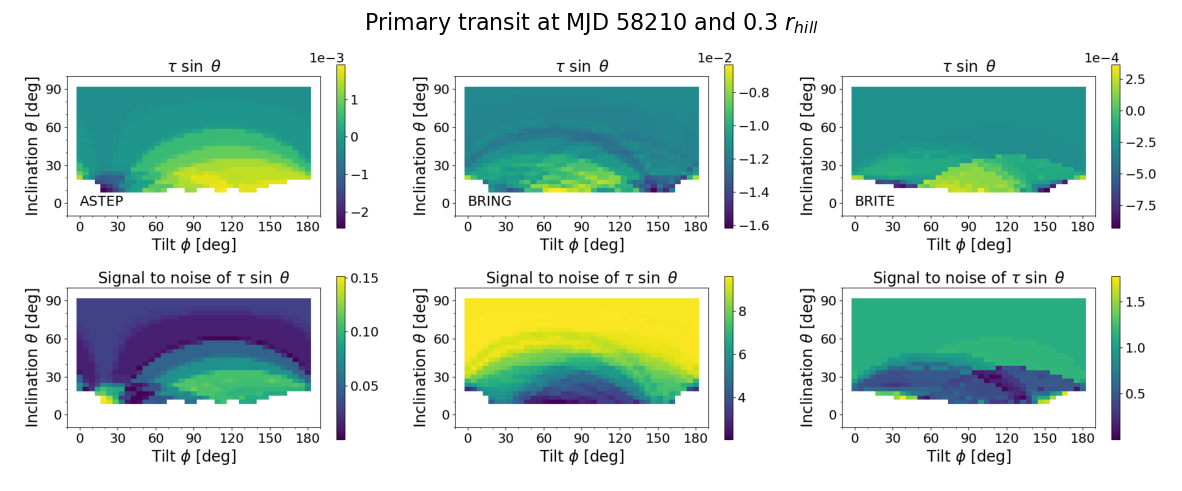

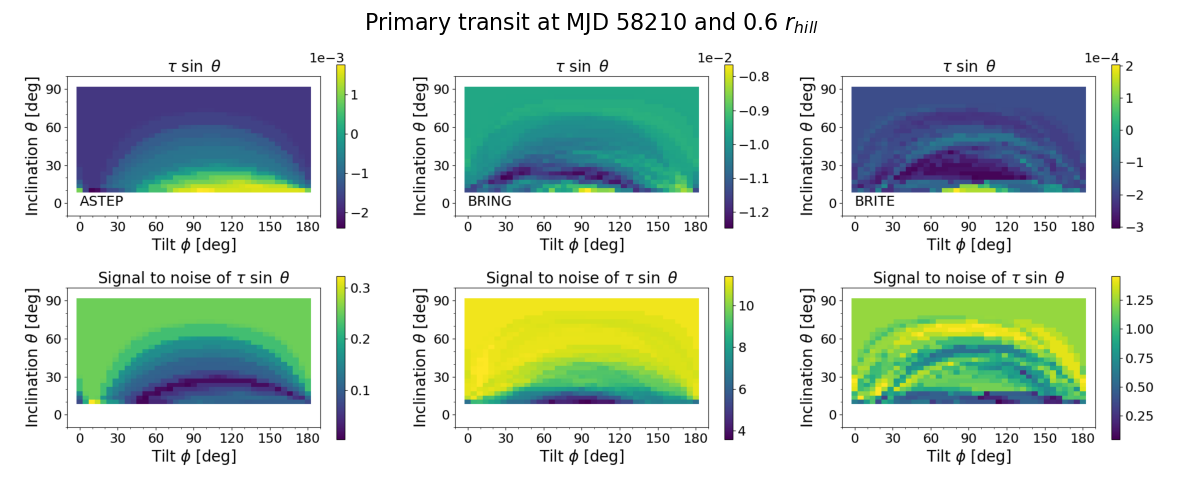

In [5]:
"""first primary transit"""

#plot disk optical depth for different tilts and inclinations for all instrumetns
def plot_diskfits(t_mid, b, f_hill, title_true):
    img_astep = Image.open('Figures/CPD_models/{}_b{}/diskfit_ASTEP_{:03d}.png'.format(t_mid.value, b,int(f_hill*100)))
    img_bRing = Image.open('Figures/CPD_models/{}_b{}/diskfit_BRING_{:03d}.png'.format(t_mid.value, b,int(f_hill*100)))
    img_brite = Image.open('Figures/CPD_models/{}_b{}/diskfit_BRITE_{:03d}.png'.format(t_mid.value, b, int(f_hill*100)))
    
    
    fig, ax = plt.subplots(1,3, figsize=(15,10), sharex=False, sharey=False, gridspec_kw={'wspace':0, 'hspace':0})
    title = r"Primary transit at MJD 58210 and 0.6 $r_{hill}$"
    if title_true == True:
        title = r"Primary transit at MJD 58210 and 0.3 $r_{hill}$"
    ax[1].set_title(title, fontsize = 16)
    ax[0].imshow(img_astep)
    ax[1].imshow(img_bRing)
    ax[2].imshow(img_brite)
    
    for i in range(3):
        ax[i].axis("off")
    plt.savefig(f'Figures/CPD_models/{t_mid.value}_b{b}/{t_mid.value}_diskfit_3datasets_taumass_0{f_hill*100 }.pdf', bbox_inches='tight')
    plt.show()

"""first primary transit"""
#b = 0.1
t_mid = 58210. * u.day # time when star has closest approach to planet

plot_diskfits(t_mid, b,f_hill=0.3, title_true = True)
plot_diskfits(t_mid, b,f_hill=0.6, title_true =False)


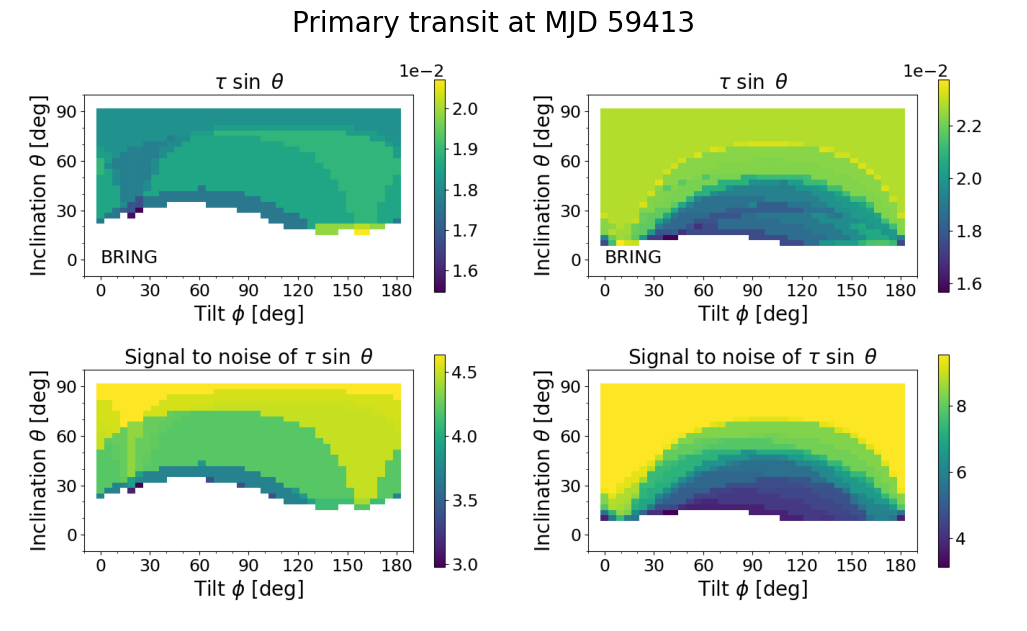

In [18]:

"""second primary transit"""

from PIL import Image
def plot_diskfits2(t_mid, b, f_hill, title_true):
    img1 = Image.open('Figures/CPD_models/{}_b{}/diskfit_taumass_{:03d}.png'.format(t_mid.value, b,int(f_hill*100)))
    img_bRing = Image.open('Figures/CPD_models/{}_b{}/diskfit_BRING_{:03d}.png'.format(t_mid.value, b,int(f_hill*100)))
    img_bRing2 = Image.open('Figures/CPD_models/{}_b{}/diskfit_BRING_{:03d}.png'.format(t_mid.value, b,int(f_hill*2*100)))
    
    
    fig, ax = plt.subplots(1,2, figsize=(13,8), sharex=False, sharey=False, gridspec_kw={'wspace':0, 'hspace':0}) #, layout='constrained')

    title = r"Primary transit at MJD 59413 "
    ax[0].imshow(img_bRing)
    ax[1].imshow(img_bRing2)
    
    for i in range(2):
        ax[i].axis("off")
    fig.suptitle(title, fontsize = 20, y=0.9)
    plt.savefig(f'Figures/CPD_models/{t_mid.value}_b{b}/{t_mid.value}_diskfit_3datasets_taumass_0{f_hill*100 }.pdf', bbox_inches='tight')
    plt.show()
    
    

b = 0.1
t_mid = 59413. * u.day
plot_diskfits2(t_mid, b,f_hill=0.3, title_true = True)
